In [317]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from collections import namedtuple
from collections import defaultdict
import os
import pickle
from time import time, sleep
import random
import csv
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [4]:
# Define the Song data structure
# Remember: namedtuples require that you plug in 
# every data type.

Song = namedtuple('Song', ['header', 'verified', 'metadata', 'lyrics'])

In [110]:
# path to the chromedriver executable
def start_driver(url):

    """This function will open a Chrome browser at the given url.
    Input: a valid URL as a string.
    Doesn't return anything, but creates a global variable *driver*
    that can be called upon elsewhere."""
    
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver

    
    # Using the global keyword so that we can call upon the driver
    # further down in the code.
    
    global driver 
    driver = webdriver.Chrome(chromedriver)

    driver.get(url)

In [4]:
# Start by opening the all rap songs page.

all_rap_songs_genius = "https://genius.com/tags/rap/all"
start_driver(all_rap_songs_genius)

In [40]:
# Use Selenium to scroll down to the bottom of the screen
# This only works if you manually focus on the Chrome browser.

for i in range (10):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(1)

In [41]:
# This code snippet is there to grab links to songs
# on the https://genius.com/tags/rap/all page.
# It appears that 1000 is the most search results
# that genius.com will display at one time.


link_selector = '//a[@class= " song_link"]'
top_songs = driver.find_elements_by_xpath(link_selector)


link_list = []

for elem in top_songs:
    link_list.append(elem.get_attribute('href'))

In [44]:
# I save the list of links as a pickle.
# That way, I don't have to do this again.

with open('links.pkl', 'wb') as link_pickle:
    pickle.dump(link_list,link_pickle)

In [3]:
# If I pick up again I can just pull from the pickle

with open('links.pkl', 'rb') as link_pickle:
    link_list = pickle.load(link_pickle)

In [109]:
def scrape_info(list_of_urls):
    
    """This function uses the Chrome driver to visit 
    every page on a list of Genius links,
    and gathers the info I want to analyze.
    Input needs to be:
    a list of links to Genius pages, otherwise it won't work. 
    Output will be:
    a dict of named tuples of the Song format."""

    dict_of_songs = defaultdict(Song)

    for i, url in enumerate(list_of_urls):
        driver.get(url)
        driver.execute_script(
            "window.scrollTo(0, document.body.scrollHeight);")
        sleep(.5+2*random.random())

        # Gather and filter metadata

        views_regex = re.compile('views', re.IGNORECASE)
        contrib_regex = re.compile('contributors', re.IGNORECASE)
        tag_regex = re.compile('(\w+,\s\w+)+')

        all_metadata = driver.find_elements_by_class_name('metadata_with_icon')

        filtered_metadata = [metadata.text for metadata in all_metadata
                             if re.search(views_regex, metadata.text)
                             or re.search(contrib_regex, metadata.text)
                             or re.search(tag_regex, metadata.text)]

        # Scrape raw lyrics

        lyrics_string = ''

        lyrics = driver.find_elements_by_class_name('song_body-lyrics')
        for lyric in lyrics:
            lyrics_string += lyric.text

        # Scrape header

        header_string = driver.find_element_by_class_name(
            'header_with_cover_art-primary_info').text

        # Determine whether artist has contributed to their song page

        try:
            ver_art = driver.find_element_by_class_name(
                'song_verified_artists-section')
            verified_bool = True
        except:
            verified_bool = False
            
        # Create Song named tuple and add to dictionary

        dict_of_songs[url] = Song(header=header_string, lyrics=lyrics_string,
                                  verified=verified_bool, metadata=filtered_metadata)
        if (i+1 % 100 == 0):
            time.sleep(320)

    return dict_of_songs

In [6]:
# Pickling the song dict
with open('songs_dict.pkl', 'wb') as song_file:
    pickle.dump(song_dict, song_file)

In [5]:
# Unpickling the song dict
with open('songs_dict.pkl', 'rb') as song_file:
    song_dict = pickle.load(song_file)

In [100]:
song_list = list(song_dict.keys())[:20]

In [333]:
mercy = song_dict['https://genius.com/Kanye-west-mercy-lyrics']

In [336]:
clean_lyrics(mercy.lyrics)

'\nwell, it is a weepin and a moanin and a gnashin of teeth\nit is a weepin and a mournin and a gnashin of teeth\nit is a— when it comes to my sound which is the champion sound\nbelieve, believe\n\n\no-o-o-o-o-okay, lamborghini mercy\nyour chick, she so thirsty\ni-i-i-i-im in that two-seat lambo\nwith your girl, she tryna jerk me believe\no-o-o-o-o–okay, lamborghini mercy\nyour chick, she so thirsty\ni–i–i–i–im in that two-seat lambo\nwith your girl, she tryna jerk me\no-o-o-o-o-okay, lamborghini mercy swerve\nyour chick, she so thirsty swerve\ni-i-i-i-im in that two-seat lambo\nwith your girl, she tryna jerk me woah believe\no-o-o-o-o-okay, lamborghini mercy\nyour chick, she so thirsty boy\ni-i-i-i-im in that two-seat lambo boy\nwith your girl, she tryna jerk me\n\n\nokay, drop it to the floor, make that ass shake shake, shake\nwoah, make the ground move: thats an ass quake\nbuilt a house up on that ass: thats an ass-tate\nroll–roll–roll my weed on it: thats an ass tray\nsay, ye, say,

In [335]:
def clean_lyrics(raw_lyrics):
    
    # This code snippet removes the header

    header_regex = re.compile('^.+\n')
        
    # This code removes the footer

    footer_regex = re.compile('\d+ Embed.+', re.DOTALL)
    
    # This should remove the little snippets in brackets

    bracket_regex = re.compile(r'\[.+\]')
    
    # This should remove the special characters that creep in
    
    character_regex = re.compile(r'''[\(\)\'\"\!\?]''')
    
    cleaned_lyrics = re.sub(footer_regex, '', raw_lyrics)
    cleaned_lyrics = re.sub(header_regex, '', cleaned_lyrics)
    cleaned_lyrics = re.sub(bracket_regex, '', cleaned_lyrics)
    cleaned_lyrics = re.sub(character_regex, '', cleaned_lyrics)
    
    return cleaned_lyrics.lower()

In [337]:
def load_semantic_fields(path):
    # semantic fields
    fields = []
    with open(path) as csv_file:
        dict_reader = csv.reader(csv_file, delimiter=',')
        for row in dict_reader:
            fields.append(row)
    
    global rel_sem_field, curse_sem_field, clothes_sem_field, cars_sem_field, foreign_sem_field

    rel_sem_field = set(fields[0])
    curse_sem_field = set(fields[1])
    clothes_sem_field = set(fields[2])
    cars_sem_field = set(fields[3])
    
    # names of tags I want to filter out
    foreign_sem_field = set(fields[4])

In [367]:
load_semantic_fields('semantic_fields.csv')

In [359]:
def process_songs(dict_of_songs):
    
    """This function takes a dictionary of Song named tuples
    and returns a list of dictionaries with just the numerical and categorical info
    for each song which to be used in the dataframe."""

    dict_list = []

    for link in dict_of_songs:
        song = dict_of_songs[link]

        info_dict = {'title': '',
                     'artist': '',
                     'words': 0,
                     'views': 0,
                     'contrib': 0,
                     'tags': '',
                     'religion': 0,
                     'curse': 0,
                     'clothes': 0,
                     'cars': 0,
                     'producer': '',
                     'verified': None}

        if song.verified:
            info_dict['verified'] = 1
        else:
            info_dict['verified'] = 0
        
        lyrics = clean_lyrics(song.lyrics)
        word_list = lyrics.split()
        song_length = len(word_list)
        info_dict['words'] = song_length

        for word in word_list:
            if word in rel_sem_field:
                info_dict['religion'] += 1
            elif word in curse_sem_field:
                info_dict['curse'] += 1
            elif word in clothes_sem_field:
                info_dict['clothes'] += 1
            elif word in cars_sem_field:
                info_dict['cars'] += 1
        info_dict['religion'] = 100 * info_dict['religion'] / song_length
        info_dict['curse'] = 100 * info_dict['curse'] / song_length
        info_dict['clothes'] = 100 * info_dict['clothes'] / song_length
        info_dict['cars'] = 100 * info_dict['cars'] / song_length

        # This should extract the number of views from the metadata

        info_dict['views'] = int(song.metadata[0].split()[0].replace(',', ''))
        
        # This should extract the number of contributors from the metadata

        info_dict['contrib'] = int(song.metadata[1].split()[0].replace(',', ''))
        
        # This should get the tags
        
        try:
            info_dict['tags'] = song.metadata[2]
        except:
            info_dict['tags'] = ''

        # This should get the title from the header

        info_dict['title'] = song.header.split('\n')[0]

        # This should get the artist name from the header

        info_dict['artist'] = song.header.split('\n')[1]

        # This should get the producer name from the header
        # If there is no producer, this should be None.

        producer_regex = re.compile('Produced by (.+)')
        try:
            info_dict['producer'] = re.match(producer_regex, song.header.split('\n')[2]).group(1)
        except:
            info_dict['producer'] = ''
        
        dict_list.append(info_dict)

        
    return dict_list

In [368]:
dl = process_songs(song_dict)

In [248]:
foreign_sem_field

{'France', 'German', 'Germany', 'Korean', 'Russia', 'Russian', 'Turkey'}

In [369]:
df = pd.DataFrame(dl)

In [370]:
df['tags'] = df.tags.apply(lambda x: foreign_to_nan(x))

df = df.dropna(axis = 0, how = 'any')

In [250]:
def foreign_to_nan(tags):
    
    """I use this to filter out songs that are in a foreign language.
    """
    
    if not tags:
        return tags
    for tag in tags.split(', '):
        if tag in foreign_sem_field:
            return np.nan
    return tags


In [276]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['cars', 'clothes', 'curse', 'religion', 'verified','contrib']], df['views'], test_size=0.33, random_state=20)
m = LinearRegression()
m.fit(X_train, y_train)
m.score(X_train, y_train)

0.4123419206351015

In [277]:
m.score(X_test,y_test)

0.38013464084507353

In [393]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['cars', 'clothes', 'curse', 'religion', 'verified','contrib']], df['views'], test_size=0.33, random_state=42)
p = PolynomialFeatures(degree = 2)
p.fit_transform(X_train)

array([[1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.7424e+04],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        9.7969e+04],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.1100e+02,
        1.2321e+04],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.6900e+02,
        2.8561e+04],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.7600e+02,
        3.0976e+04],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.5600e+02,
        2.4336e+04]])

In [390]:
df_analysis = df.loc[:,['cars','clothes','contrib','curse','religion','verified','views']]

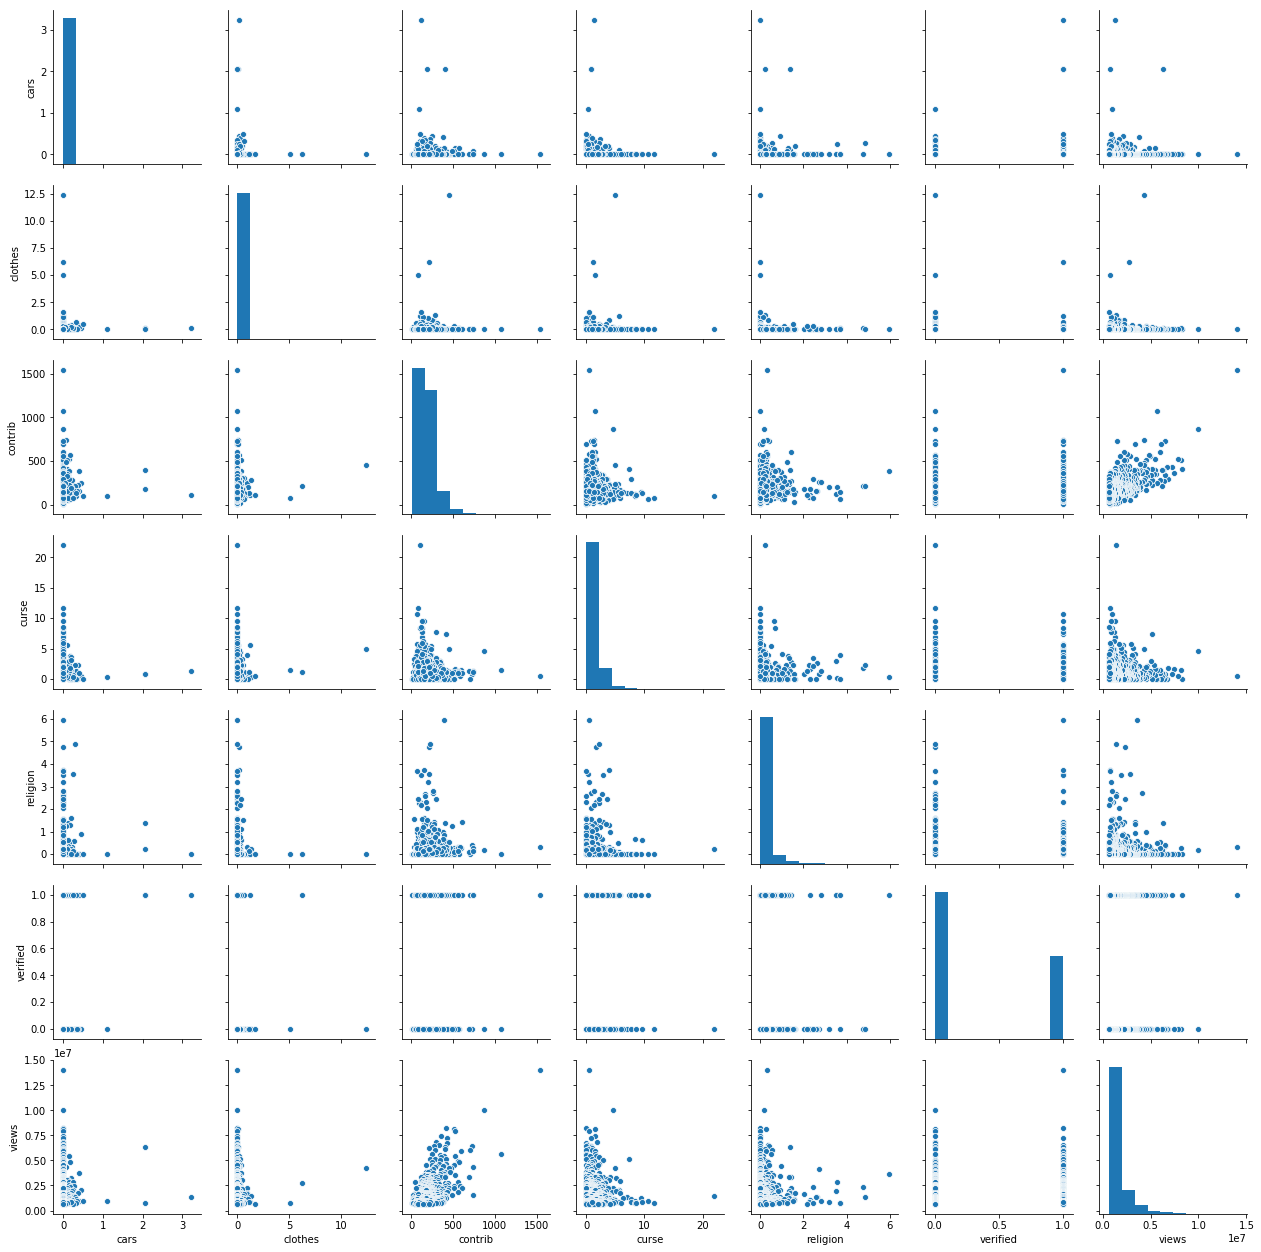

In [392]:
sns.pairplot(df_analysis)

In [387]:
def split_and_validate(X, y):
    
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', coef) 

In [388]:
split_and_validate(df.loc[:,['cars', 'clothes', 'curse', 'religion', 'verified','contrib']],df.loc[:,['views']])


Validation R^2 score was: 0.13076315746759093
Feature coefficient results: 

cars : [385984.56446628 -79970.35280457   8990.60337281 -79784.89538883
 106365.10630746   6982.01653305]


In [371]:
cars_df = df[df['cars'] != 0]

In [372]:
curse_df = df[df['curse'] != 0]

In [378]:
# Define the model
lm1 = smf.ols('views ~ cars + clothes + curse + religion + verified + contrib', data=curse_df)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     91.97
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           1.26e-87
Time:                        18:01:06   Log-Likelihood:                -12195.
No. Observations:                 803   AIC:                         2.440e+04
Df Residuals:                     796   BIC:                         2.444e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.577e+05   7.64e+04      3.372      0.001    1.08e+05    4.08e+05
cars        2.489e+05   2.04e+05      1.218      0.224   -1.52e+05     6.5e+05
clothes      6.51e+04   6.36e+04      1.023      0.306   -5.98e+04     1.9e+05
curse       2.228e+04   2.17e+04      1.028      0.304   -2.03e+04    6.48e+04
religion   -5.705e+04   6.48e+04     -0.880      0.379   -1.84e+05    7.02e+04
verified    1.963e+05   7.17e+04      2.739      0.006    5.56e+04    3.37e+05
contrib     6447.5963    283.741     22.724      0.000    5890.627    7004.565
==============================================================================
Omnibus:                      251.590   Durbin-Watson:                   0.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              979.714
Skew:                           1.434   Prob(JB):                    1.81e-213
Kurtosis:                       7.589   Cond. No.                     1.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [114]:
"""I realized that there were some songs where
the driver failed to scrape the metadata.
Here's the code I used to fix it:
songs_to_fix = []
for key in song_dict:
    if not song_dict[key].metadata:
        songs_to_fix.append(key)
        
start_driver(songs_to_fix[0])
missing_info = scrape_info(songs_to_fix)
for key in missing_info:
    song_dict[key] = missing_info[key]"""